# Data Science project: Chess Openings
## Predict the best defense given White's opening type

**Author:** Matteo Ciccarese

This project is an exercise in data science, where the main goal is to analyze and predict the best defenses of black based on the openings of white in a chess game. We explored Random Forest as a machine learning model to try to identify patterns in the moves and improve the predictions. 

**As this is an educational project, any feedback, comments or suggestions to improve our approach are more than welcome! We are open to suggestions to refine the methodology and obtain more accurate results.**

### Dataset:

The High-Elo Games Chess Opening Dataset from Kaggle is a dataset that collects games played by high-level (high Elo) players, focusing on openings and early responses. It contains detailed information about each game, such as the opening moves of white and black, the name of the opening, the outcome of the game, and other details useful for analyzing the best strategies. This dataset is ideal for studying opening trends and evaluating the most effective defenses for black based on white's choices.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chess-opening-dataset/high_elo_opening.csv


## Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading and Exploratory Data Analysis (EDA)

In [3]:
df = pd.read_csv('/kaggle/input/chess-opening-dataset/high_elo_opening.csv')
df.head()

,opening_name,side,num_games,ECO,last_played_date,perf_rating,avg_player,perc_player_win,perc_draw,pec_opponent_win,...,move2b,move3w,move3b,move4w,move4b,perc_white_win,perc_black_win,white_odds,white_wins,black_wins
0,"Alekhine Defense, Balogh Variation",white,692,B03,2018-06-22,2247,2225,40.8,24.3,35.0,...,Nd5,d4,d6,Bc4,NaN,40.8,35.0,1.165714,282.336,242.200
1,"Alekhine Defense, Brooklyn Variation",black,228,B02,2018-06-27,2145,2193,29.8,22.4,47.8,...,Ng8,NaN,NaN,NaN,NaN,47.8,29.8,1.604027,108.984,67.944
2,"Alekhine Defense, Exchange Variation",white,6485,B03,2018-07-06,2244,2194,40.8,27.7,31.5,...,Nd5,d4,d6,c4,Nb6,40.8,31.5,1.295238,2645.880,2042.775
3,"Alekhine Defense, Four Pawns Attack",white,881,B03,2018-06-20,2187,2130,39.7,23.2,37.1,...,Nd5,d4,d6,c4,Nb6,39.7,37.1,1.070081,349.757,326.851
4,"Alekhine Defense, Four Pawns Attack, Fianchett...",black,259,B03,2018-05-20,2122,2178,37.8,21.2,40.9,...,Nd5,d4,d6,c4,Nb6,40.9,37.8,1.082011,105.931,97.902


In [4]:
df.describe()

,num_games,perf_rating,avg_player,perc_player_win,perc_draw,pec_opponent_win,perc_white_win,perc_black_win,white_odds,white_wins,black_wins
count,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000
mean,1846.019108,2235.945860,2236.531847,35.159395,29.914066,34.928715,39.745701,30.342410,1.448725,708.835970,557.051955
std,2739.103462,135.260392,127.723711,9.077139,8.043043,9.180450,7.671108,7.976305,0.673991,1037.027669,866.788831
min,100.000000,1583.000000,1577.000000,7.500000,4.000000,6.700000,13.600000,6.700000,0.308642,21.000000,8.946000
25%,314.750000,2157.000000,2166.000000,28.900000,24.500000,28.900000,34.800000,25.100000,1.037277,124.740500,91.026250
50%,788.500000,2252.500000,2255.000000,35.100000,29.400000,34.650000,39.100000,29.900000,1.325008,310.274000,230.952000
75%,2225.000000,2329.000000,2326.000000,41.125000,34.625000,40.525000,44.000000,35.000000,1.674116,824.243000,651.262750
max,22482.000000,2536.000000,2492.000000,77.600000,68.500000,77.500000,77.600000,64.800000,9.810127,8295.858000,8700.534000


### Key observations:
1. Games are played by players with an average rating of around 2236, which is high level.
2. Some openings are played much more than others, as the maximum number of games for an opening is 22,482, while the minimum is only 100.
3. The win percentage varies greatly:
   - White's average win rate is 39.7%, while for Black it is 30.3%.
   - Draws have an average of 29.9%.
4. White's odds (white_odds) range from 0.30 to 9.81, indicating that some openings give a large advantage.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opening_name      1884 non-null   object 
 1   side              1884 non-null   object 
 2   num_games         1884 non-null   int64  
 3   ECO               1884 non-null   object 
 4   last_played_date  1884 non-null   object 
 5   perf_rating       1884 non-null   int64  
 6   avg_player        1884 non-null   int64  
 7   perc_player_win   1884 non-null   float64
 8   perc_draw         1884 non-null   float64
 9   pec_opponent_win  1884 non-null   float64
 10  moves_list        1884 non-null   object 
 11  move1w            1884 non-null   object 
 12  move1b            1869 non-null   object 
 13  move2w            1814 non-null   object 
 14  move2b            1744 non-null   object 
 15  move3w            1628 non-null   object 
 16  move3b            1501 non-null   object 


### Key observations
1. 1884 rows and 24 columns → The dataset is manageable in size for analysis.
2. Data types:
3. Numeric (int64 and float64) → Win percentages, ratings, number of games.
   
   Text (object) → Opening names (opening_name), ECO code (ECO), moves (move1w, move1b, etc.).
   
   Missing values in move columns (move1b, move2w, etc.) → The further you go in moves, the more data is missing.
   
   This is normal because not all openings follow the same depth of moves.
   
5. The last_played_date column is object (string) → It should be converted to datetime format for time analysis.

### Handling missing values

In [6]:
df.isnull().sum()

opening_name          0
side                  0
num_games             0
ECO                   0
last_played_date      0
perf_rating           0
avg_player            0
perc_player_win       0
perc_draw             0
pec_opponent_win      0
moves_list            0
move1w                0
move1b               15
move2w               70
move2b              140
move3w              256
move3b              383
move4w              544
move4b              698
perc_white_win        0
perc_black_win        0
white_odds            0
white_wins            0
black_wins            0
dtype: int64

Since the missing values represent moves and these cannot be replaced by averages, most used values in the column or anything else, they are forced to eliminate these.

In [7]:
# Select only columns related to missing moves
move_columns = ['move1w', 'move1b', 'move2w', 'move2b', 'move3w', 'move3b', 'move4w', 'move4b']

# Filter rows that contain missing values ​​in move columns
missing_moves = df[move_columns].isnull().any(axis=1)

# Display only rows with missing values ​​in move columns
df_with_missing_moves = df[missing_moves]

# Display result
df_with_missing_moves[move_columns]


,move1w,move1b,move2w,move2b,move3w,move3b,move4w,move4b
0,e4,Nf6,e5,Nd5,d4,d6,Bc4,NaN
1,e4,Nf6,e5,Ng8,NaN,NaN,NaN,NaN
7,e4,Nf6,NaN,NaN,NaN,NaN,NaN,NaN
9,e4,Nf6,d3,NaN,NaN,NaN,NaN,NaN
10,e4,Nf6,e5,Nd5,d4,d6,Nf3,NaN
...,...,...,...,...,...,...,...,...
1878,Nf3,d5,b4,NaN,NaN,NaN,NaN,NaN
1879,Nf3,c5,NaN,NaN,NaN,NaN,NaN,NaN
1880,Nf3,c6,NaN,NaN,NaN,NaN,NaN,NaN
1881,Nf3,Nf6,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop rows that have NaN values in any of the specified columns
df = df.dropna(subset=move_columns)

df.isnull().sum()

opening_name        0
side                0
num_games           0
ECO                 0
last_played_date    0
perf_rating         0
avg_player          0
perc_player_win     0
perc_draw           0
pec_opponent_win    0
moves_list          0
move1w              0
move1b              0
move2w              0
move2b              0
move3w              0
move3b              0
move4w              0
move4b              0
perc_white_win      0
perc_black_win      0
white_odds          0
white_wins          0
black_wins          0
dtype: int64

### Data Visualization

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


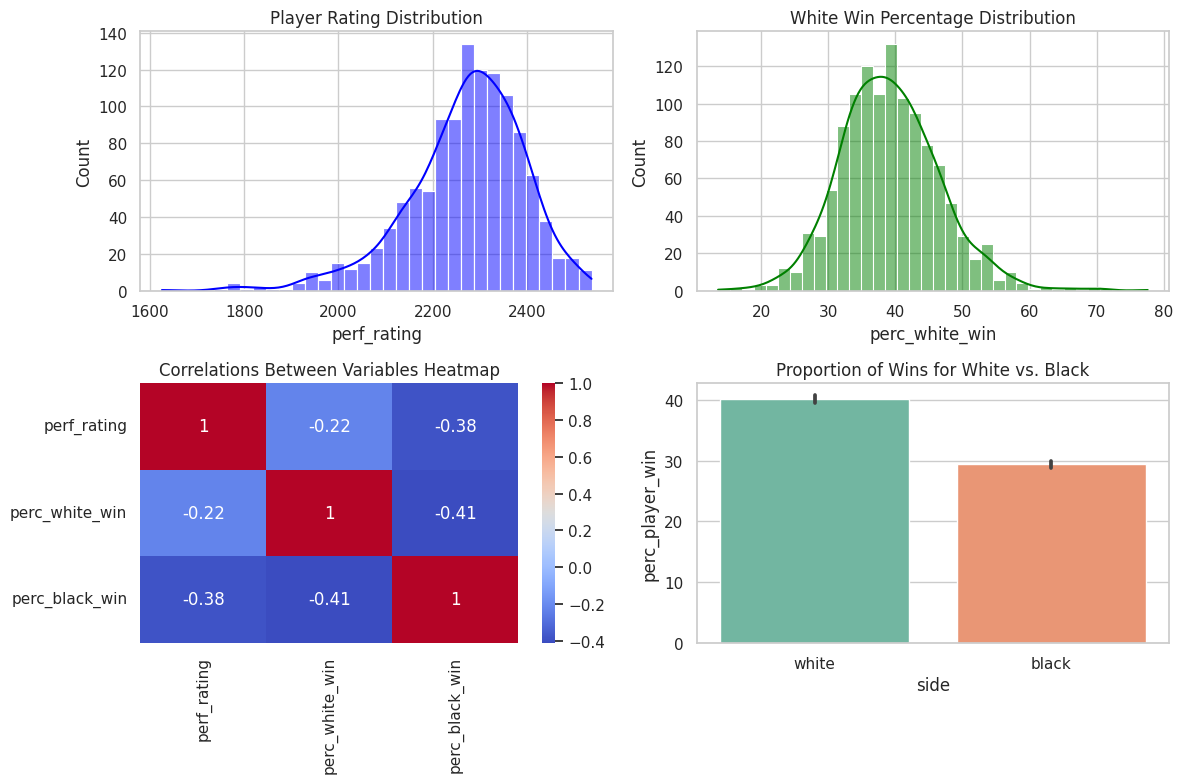

In [9]:
# Graphics Settings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# 1. Player Rating Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['perf_rating'], kde=True, color='blue')
plt.title('Player Rating Distribution')

# 2. White Win Percentage
plt.subplot(2, 2, 2)
sns.histplot(df['perc_white_win'], kde=True, color='green')
plt.title('White Win Percentage Distribution')

# 3. Correlation between 'perf_rating', 'perc_white_win', 'perc_black_win'
plt.subplot(2, 2, 3)
correlation_matrix = df[['perf_rating', 'perc_white_win', 'perc_black_win']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlations Between Variables Heatmap')

# 4. Proportion of Wins for White vs. Black
plt.subplot(2, 2, 4)
sns.barplot(x='side', y='perc_player_win', data=df, estimator='mean', palette='Set2')
plt.title('Proportion of Wins for White vs. Black')

plt.tight_layout()
plt.show()

The graphs do not tell us anything new, but here are some observations.

1. **Player Rating Distribution (Top Left Graph):**
     - Most scores are concentrated around 2200-2400, with a distribution that seems to approximate normal.
2. **White Win Percentage Distribution (Top Right Graph):**
     - White win percentage is mostly distributed between 30% and 50%, with an average of around 40%.
3. **Variable Correlation Heatmap (Bottom Left Graph):**
     - There is a moderate negative correlation between player ratings and win percentages (for both whites and blacks).
     - White and black win percentages are strongly and negatively correlated (-0.41).
4. **Win Ratio (White vs. Black) (Bottom Right Chart):**
     - Whites win more often on average than blacks, with a noticeable difference in the bar.
     - This confirms the historical advantage of white moving first.

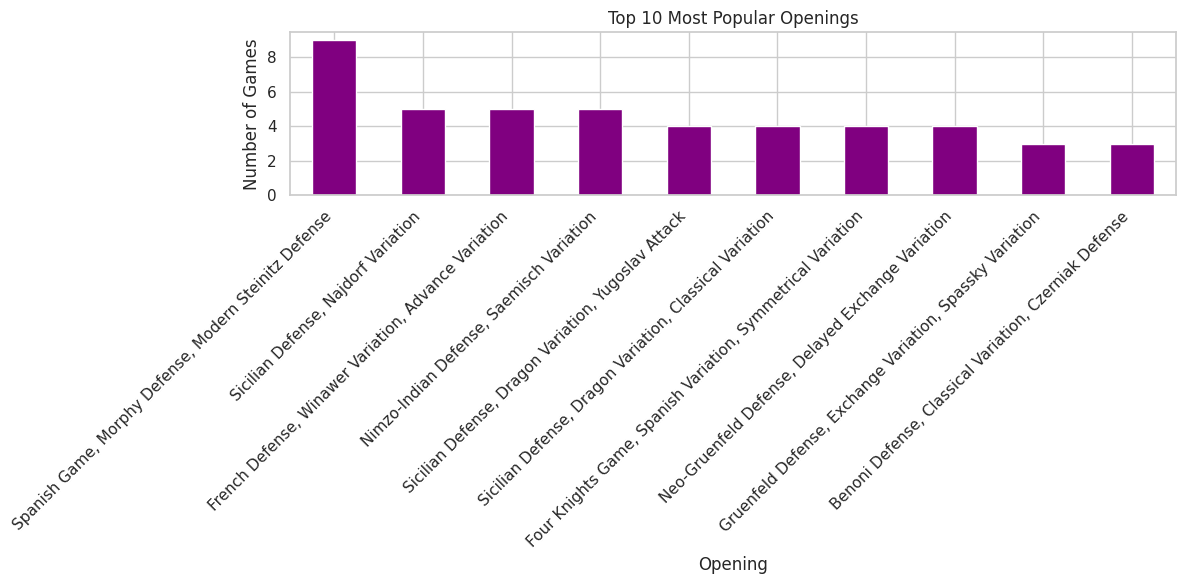

In [10]:
# Top 10 Most Popular Openings
top_openings = df['opening_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_openings.plot(kind='bar', color='purple')

plt.title('Top 10 Most Popular Openings')
plt.xlabel('Opening')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

The graph represents the 10 most used openings by players in this dataset.

In [11]:
df.columns

Index(['opening_name', 'side', 'num_games', 'ECO', 'last_played_date',
       'perf_rating', 'avg_player', 'perc_player_win', 'perc_draw',
       'pec_opponent_win', 'moves_list', 'move1w', 'move1b', 'move2w',
       'move2b', 'move3w', 'move3b', 'move4w', 'move4b', 'perc_white_win',
       'perc_black_win', 'white_odds', 'white_wins', 'black_wins'],
      dtype='object')

Let's create a copy of the DataFrame with only the columns related to the opening of the game.

Reason for .copy(): Avoids the SettingWithCopyWarning by modifying an independent copy of the DataFrame.

In [12]:
# Extract only columns relevant to the opening
openings_df = df[['opening_name', 'move1w', 'move1b', 'move2w', 'move2b', 'move3w', 'move3b', 'move4w', 'move4b']].copy()

# Show first lines to verify
openings_df.head()

,opening_name,move1w,move1b,move2w,move2b,move3w,move3b,move4w,move4b
2,"Alekhine Defense, Exchange Variation",e4,Nf6,e5,Nd5,d4,d6,c4,Nb6
3,"Alekhine Defense, Four Pawns Attack",e4,Nf6,e5,Nd5,d4,d6,c4,Nb6
4,"Alekhine Defense, Four Pawns Attack, Fianchett...",e4,Nf6,e5,Nd5,d4,d6,c4,Nb6
5,"Alekhine Defense, Four Pawns Attack, Main Line",e4,Nf6,e5,Nd5,d4,d6,c4,Nb6
6,"Alekhine Defense, Four Pawns Attack, Trifunovi...",e4,Nf6,e5,Nd5,d4,d6,c4,Nb6


### Preprocessing Moves

we will use 'enumerate(..., start=1)' to assign each move a numeric value starting from 1.

In [13]:
# Create a move mapping dictionary
unique_moves = set(openings_df.drop(columns=['opening_name']).values.flatten())
move_dict = {move: idx for idx, move in enumerate(unique_moves, start=1)}

We map now, moves because machine learning models work better with numerical data than with text strings.

Chess moves (e4, d4, Nf3, etc.) are strings.
Machine learning algorithms require numerical inputs to calculate distances, correlations, and patterns in the data.
We transform moves into an interpretable format

In [14]:
# Mapping moves to numeric values
for col in openings_df.columns:
    if col != 'opening_name':
       openings_df[col] = openings_df[col].map(move_dict)

# Show first lines for verification
openings_df.head()

,opening_name,move1w,move1b,move2w,move2b,move3w,move3b,move4w,move4b
2,"Alekhine Defense, Exchange Variation",43,95,69,97,107,110,3,44
3,"Alekhine Defense, Four Pawns Attack",43,95,69,97,107,110,3,44
4,"Alekhine Defense, Four Pawns Attack, Fianchett...",43,95,69,97,107,110,3,44
5,"Alekhine Defense, Four Pawns Attack, Main Line",43,95,69,97,107,110,3,44
6,"Alekhine Defense, Four Pawns Attack, Trifunovi...",43,95,69,97,107,110,3,44


Now each move is represented by a unique number, useful for training a Machine Learning model!

### Data Breakdown

In [15]:
from sklearn.model_selection import train_test_split

# Select features (White's moves) and targets (Black's moves)
X = openings_df[['move1w', 'move2w', 'move3w', 'move4w']] # White's moves
y = openings_df[['move1b', 'move2b', 'move3b', 'move4b']] # Black's responses

# Split into training (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training Set Size: {X_train.shape}, {y_train.shape}")
print(f"Test Set Size: {X_test.shape}, {y_test.shape}")

Training Set Size: (948, 4), (948, 4)
Test Set Size: (238, 4), (238, 4)


### Machine Learning
## Random Forest
We chose Random Forest because it is a robust and easily interpretable model that handles datasets with both numeric and categorical variables well. It also avoids overfitting thanks to its multiple decision tree structure and offers a feature importance assessment, which is useful for understanding the influence of each White move. Finally, Random Forest is relatively fast to train, which makes it ideal for applications where speed and generalization are crucial.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report

# Create the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test labels
y_pred = rf_model.predict(X_test)

# Calculate precision for each column separately
for i in range(y_test.shape[1]): # For each target (move1b, move2b, ...)
    print(f"Precision for {y_test.columns[i]}:")
    print(precision_score(y_test.iloc[:, i], y_pred[:, i], average='macro')) # Use 'macro' to average the precisions
    print("\n")

Precision for move1b:
0.7299774718685367


Precision for move2b:
0.7256559874613835


Precision for move3b:
0.6319255907491201


Precision for move4b:
0.30948566251634246




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

The output indicates that the model is producing low accuracies for some targets, especially move4b, and there are warnings about classes for which the model has not made any predictions.

### Analysis of the results:
1. **Precision for moves 1b, 2b and 3b is quite decent**:
   - move1b: 0.73
   - move2b: 0.70
   - move3b: 0.63

These values suggest that the model is doing a fairly good job of predicting the responses for black's first three moves.

2. **Precision for move4b** is very low (0.31). This indicates that the prediction for black's fourth move is quite inaccurate.
3. **Warning**: The warning we see is due to the fact that some labels (move classes) have not been predicted by the model. This can happen when your    model only predicts some of the available classes and ignores others.

## Conclusions:

I think that the drop in accuracy as you advance through the moves is a natural phenomenon in chess opening prediction models.

**Reasons for the drop in accuracy**:
1. **Increasing variability** – The first moves of a chess game often follow well-established patterns (such as standard openings), making it easier to predict black's response. As the game progresses, the possibilities multiply and the moves become less predictable.

2. **Influence of previous moves** – Each subsequent move depends on the previous choices of both players. This introduces a sequential dependency that a Random Forest model (based on independent decision trees) does not capture very well.

3. **Cumulative model errors** – If the model makes small errors in the first moves, these propagate to subsequent predictions, reducing the accuracy on later moves.

#### I think the future of this project is to use a model that better captures the temporal dependence, such as recurrent neural networks (LSTM/GRU), which are designed to work with sequential data.